In [1]:
#check gpu
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#imports
import os
import re
from six.moves import urllib

import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from official.vision.beta.configs import video_classification
from official.vision.beta.projects.movinet.configs import movinet as movinet_configs
from official.vision.beta.projects.movinet.modeling import movinet
from official.vision.beta.projects.movinet.modeling import movinet_layers
from official.vision.beta.projects.movinet.modeling import movinet_model

/home/evan/.local/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.7.0-dev20210806). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [3]:
movinet_a2_hub_url = 'https://tfhub.dev/tensorflow/movinet/a2/base/kinetics-600/classification/1'

inputs = tf.keras.layers.Input(
    shape=[None, None, None, 3],
    dtype=tf.float32)

encoder = hub.KerasLayer(movinet_a2_hub_url, trainable=True)

# Important: To use tf.nn.conv3d on CPU, we must compile with tf.function.
encoder.call = tf.function(encoder.call, experimental_compile=True)

# [batch_size, 600]
outputs = encoder(dict(image=inputs))

model = tf.keras.Model(inputs, outputs)

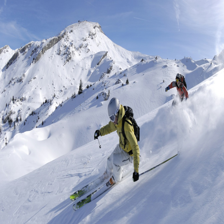

In [4]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/8/84/Ski_Famille_-_Family_Ski_Holidays.jpg'
image_height = 224
image_width = 224

with urllib.request.urlopen(image_url) as f:
  image = Image.open(f).resize((image_height, image_width))
video = tf.reshape(np.array(image), [1, 1, image_height, image_width, 3])
video = tf.cast(video, tf.float32) / 255.

image

In [6]:
output = model(video)
output_label_index = tf.argmax(output, -1)[0].numpy()

print(output_label_index)

UnimplementedError: DNN library is not found. [Op:__inference_call_155674]

In [7]:
num_classes = 101
num_examples = {'train':9537 , 'test':3783} #from tensorflow site

In [8]:
batch_size = 8
num_frames = 8
frame_stride = 10
resolution = 172

def format_features(features):
  video = features['video']
  video = video[:, ::frame_stride]
  video = video[:, :num_frames]

  video = tf.reshape(video, [-1, video.shape[2], video.shape[3], 3])
  video = tf.image.resize(video, (resolution, resolution))
  video = tf.reshape(video, [-1, num_frames, resolution, resolution, 3])
  video = tf.cast(video, tf.float32) / 255.

  label = tf.one_hot(features['label'], num_classes)
  return (video, label)

train_dataset = tfds.load(
    'ucf101', 
    data_dir ='/home/evan/Datasets/tensorflow', 
    split='train',
    batch_size=batch_size,
    shuffle_files=True)
train_dataset = train_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(2)

test_dataset = tfds.load(
    'ucf101', 
    data_dir ='/home/evan/Datasets/tensorflow', 
    split='train',
    batch_size=batch_size)
test_dataset = test_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=True)
test_dataset = test_dataset.prefetch(2)

,,,,,,,

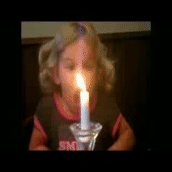
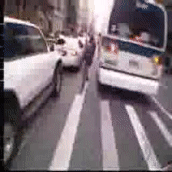
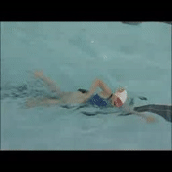
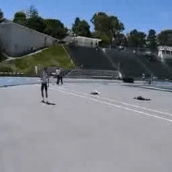
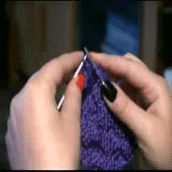
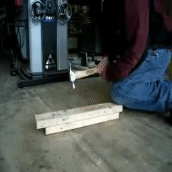
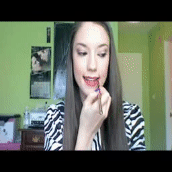
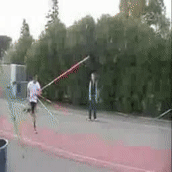

In [9]:
videos, labels = next(iter(train_dataset))
media.show_videos(videos.numpy(), codec='gif', fps=5)

In [10]:
model_id = 'a0'

tf.keras.backend.clear_session()

backbone = movinet.Movinet(
    model_id=model_id)
model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=600)
model.build([batch_size, num_frames, resolution, resolution, 3])

# Load pretrained weights from TF Hub
movinet_hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/base/kinetics-600/classification/1'
movinet_hub_model = hub.KerasLayer(movinet_hub_url, trainable=True)
pretrained_weights = {w.name: w for w in movinet_hub_model.weights}
model_weights = {w.name: w for w in model.weights}

  #rename weights appropriately
for name in model_weights:
  pretrained_name = re.sub(r'block(\d)_', r'b\1/', name)
  pretrained_name = re.sub(r'layer(\d)', r'l\1', pretrained_name)
  model_weights[name].assign(pretrained_weights[pretrained_name])

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs
model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=num_classes)
model.build([batch_size, num_frames, resolution, resolution, 3])

# Freeze all layers except for the final classifier head
for layer in model.layers[:-1]:
  layer.trainable = False
model.layers[-1].trainable = True

In [11]:
num_epochs = 3

train_steps = num_examples['train'] // batch_size
total_train_steps = train_steps * num_epochs
test_steps = num_examples['test'] // batch_size

loss_obj = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1)

metrics = [
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

callbacks = [
    tf.keras.callbacks.TensorBoard(),
]

In [15]:
results = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks,
    validation_freq=1,
    verbose=1)

Epoch 1/3


UnimplementedError:  DNN library is not found.
	 [[node movinet_classifier_1/movinet/stem/stem/conv3d/StatefulPartitionedCall
 (defined at /home/evan/.local/lib/python3.6/site-packages/official/vision/beta/modeling/layers/nn_layers.py:959)
]] [Op:__inference_train_function_269484]

Errors may have originated from an input operation.
Input Source operations connected to node movinet_classifier_1/movinet/stem/stem/conv3d/StatefulPartitionedCall:
In[0] IteratorGetNext (defined at /home/evan/.local/lib/python3.6/site-packages/keras/engine/training.py:841)	
In[1] movinet_classifier_1/movinet/stem/stem/conv3d/262211:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 619, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
>>>     self._callback(*self._args)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
>>>     return f(*args, **kw)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 358, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
>>>     return f(*args, **kw)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
>>>     return f(*args, **kw)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
>>>     user_expressions, allow_stdin,
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
>>>     return f(*args, **kw)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-12-091e4650a8cd>", line 9, in <module>
>>>     verbose=1)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 1184, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 853, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 842, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 835, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 787, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 1037, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/functional.py", line 415, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/functional.py", line 550, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 1037, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/functional.py", line 415, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/functional.py", line 550, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 1037, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/official/vision/beta/projects/movinet/modeling/movinet_layers.py", line 1324, in call
>>>     return self._stem(inputs, states=states)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 1037, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/official/vision/beta/projects/movinet/modeling/movinet_layers.py", line 641, in call
>>>     x = self._conv(x)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 1037, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/evan/.local/lib/python3.6/site-packages/official/vision/beta/modeling/layers/nn_layers.py", line 959, in call
>>>     return conv_fn(inputs)
>>> 

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 0